In [ ]:
from google.colab import files
uploaded = files.upload()  # Select your CSV file

Saving cleaned_dataset.csv to cleaned_dataset.csv


In [3]:
import pandas as pd

df = pd.read_csv("cleaned_dataset.csv")
df.head()

,full_title,isbn13,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,Gilead,9780002005883,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,Spider's Web : A Novel,9780002261982,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,Rage of angels,9780006178736,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
3,The Four Loves,9780006280897,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0
4,The Problem of Pain,9780006280934,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0


/tmp/ipython-input-3635007421.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Category', data=top_categories, palette='viridis')


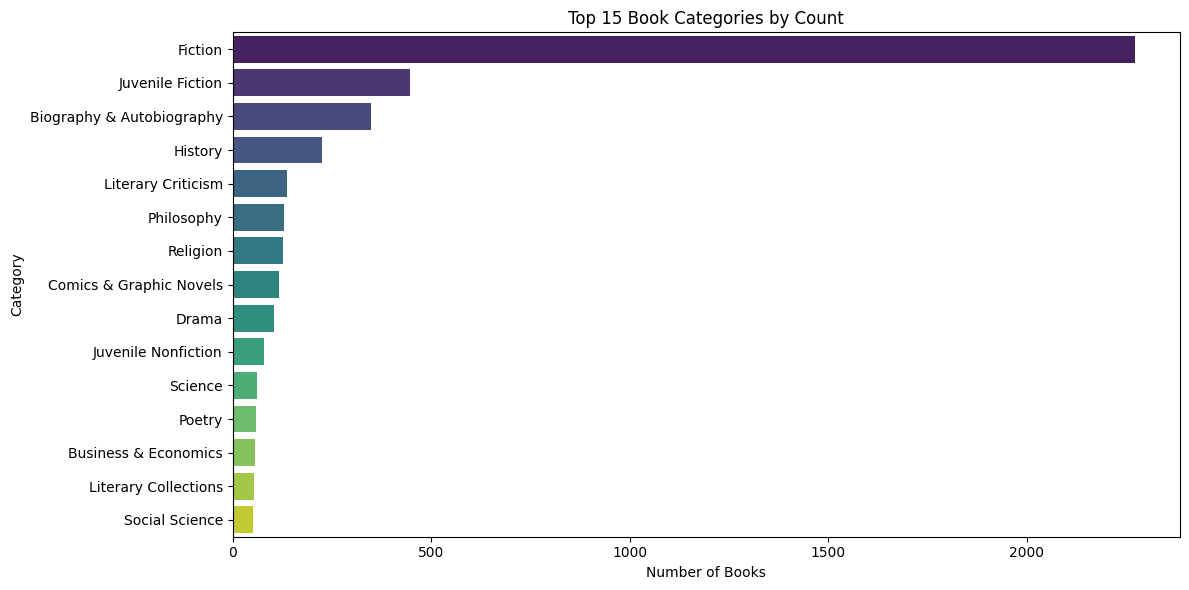

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each category
category_counts = df['categories'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Display the top 10 categories for better readability
top_categories = category_counts.head(15)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Category', data=top_categories, palette='viridis')
plt.title('Top 15 Book Categories by Count')
plt.xlabel('Number of Books')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

as you can see theres a lot of irregular distribution of many different categories, we will convert these categories to only 3 types, (fiction, non fiction, science)

for that well will use zero shot classification by facebook bart model


In [5]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


we will make a separate column consisting of category, full title, and desscription to make prediction from the model

In [6]:
df["combined_text"] = df["full_title"].astype(str) + " " + df["description"].astype(str) + " " + df["categories"].astype(str)


In [7]:
candidate_labels = ["Fiction", "Non Fiction", "Science"]


In [9]:
from tqdm import tqdm

texts = df["combined_text"].tolist()
predicted_categories = []

batch_size = 16  # You can increase to 32 if GPU memory allows
for i in tqdm(range(0, len(texts), batch_size), desc="Categorizing"):
    batch = texts[i:i+batch_size]
    results = pipe(batch, candidate_labels, multi_label=False)
    for res in results:
        predicted_categories.append(res["labels"][0])

Categorizing: 100%|██████████| 353/353 [10:58<00:00,  1.87s/it]


In [15]:
df["predicted_category"] = predicted_categories
df.head()

,full_title,isbn13,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,combined_text,predicted_category
0,Gilead,9780002005883,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead A NOVEL THAT READERS and critics have b...,Fiction
1,Spider's Web : A Novel,9780002261982,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web : A Novel A new 'Christie for Chr...,Fiction
2,Rage of angels,9780006178736,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,"Rage of angels A memorable, mesmerizing heroin...",Fiction
3,The Four Loves,9780006280897,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves Lewis' work on the nature of lo...,Non Fiction
4,The Problem of Pain,9780006280934,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,"The Problem of Pain ""In The Problem of Pain, C...",Non Fiction


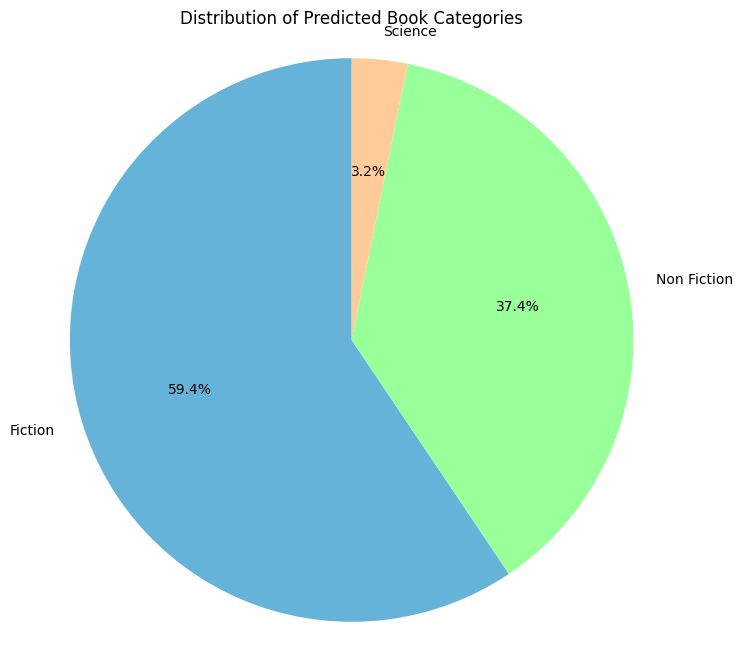

In [16]:
# Count the occurrences of each predicted category
predicted_category_counts = df['predicted_category'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(predicted_category_counts, labels=predicted_category_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3da', '#99ff99', '#ffcc99'])
plt.title('Distribution of Predicted Book Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

,full_title,isbn13,authors,thumbnail,description,published_year,average_rating,num_pages,ratings_count,predicted_category
0,Gilead,9780002005883,Marilynne Robinson,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Fiction
1,Spider's Web : A Novel,9780002261982,Charles Osborne;Agatha Christie,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Fiction
2,Rage of angels,9780006178736,Sidney Sheldon,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Fiction
3,The Four Loves,9780006280897,Clive Staples Lewis,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,Non Fiction
4,The Problem of Pain,9780006280934,Clive Staples Lewis,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,Non Fiction


In [19]:
df.to_csv("merged_category_dataset.csv", index=False)
files.download("merged_category_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>